<b> This is a machine learning project for TTS where I took the famous Titanic dataset from Kaggle, performed some data analysis, and attempted to use XGBoost to predict the survivors of the Titanic using the given data. I, started by simply opening up the data as a Pandas DataFrame. https://www.kaggle.com/c/titanic/data </b>

In [2]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
titanic = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

I decided to drop two columns, "Name" and "Ticket" as they contained a lot of unique values and they don't seem to be useful indicators of survivorship.

In [6]:
reduced = titanic.loc[:,['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']]
reduced_test = test.loc[:,['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']]
reduced

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C148,C


I then vectorized the "Sex" and "Cabin" columns by setting "male" as "0" and "female" to "1" for the former, and "NaN" to 0 and any other value to "1" for the latter. For the "Cabin" column, I assumed that if there was a missing value, that the specific passenger did not have a cabin on board the Titanic, and a sizable majority of passengers did not have a cabin.

In [7]:
def vectorize(row):
    
    if type(row['Cabin']) == float:
        row['Cabin'] = 0
    else:
        row['Cabin'] = 1
        
    if row['Sex'] == 'male':
        row['Sex'] = 0
    else:
        row['Sex'] = 1    
    return row

reduced = reduced.apply(vectorize, axis=1)
reduced_test = reduced_test.apply(vectorize, axis=1)

I proceeded with some general data visualization. I used a heatmap to plot out the correlations for all the columns apart from the "Embarked" column to look for general trends. From the figure below, we see several indicators for increased survival. These include, being in a lower numbered passenger class, such as first class, being female, having a cabin, and being young. Columns that indicated wealth, such as "PClass", "Cabin" and "Fare" were heavily correlated with one another and can potentially be reduced to a single variable using PCA or some other variable reducing method. "SibSp" and "Parch", i.e. sibling/spouse and parent/child seemed to be the least informative variables.

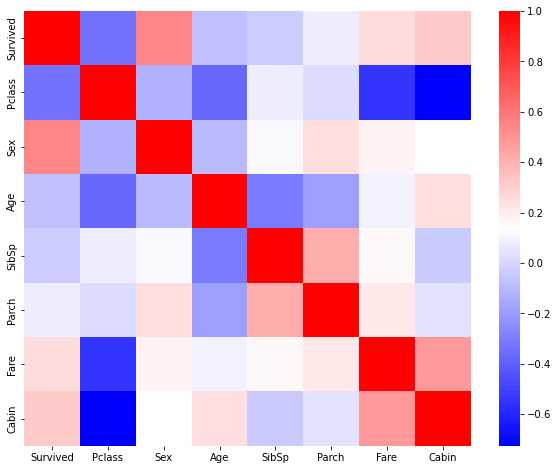

In [9]:
corrs = reduced.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='bwr')
plt.show()

The "Embarked" column is the only categorical column we have left in the dataset, representing three ports, 'S', 'C', and 'Q' from where passengers boarded the Titanic. By plotting the distribution of passengers and survivorship for each of these ports, we see that 'C' port had the highest survivorship rate of over 50 percent, with 'S' port having the lowest survivorship rate of around 30 percent as well as the largest population of passengers.

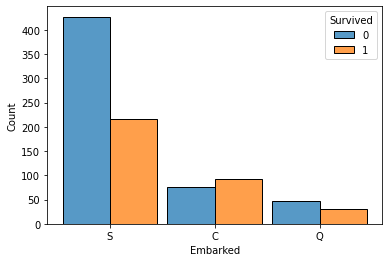

In [10]:
sns.histplot(data=reduced, x='Embarked', hue='Survived', multiple='dodge', shrink=0.9)
plt.show()

To get a bit more information about the passengers from each port, we checked the distribution of passenger class and port and found that about half of the passengers from port 'C' were first class while about half of the passengers from port 'S' were in third class, with 'Q' passengers somewhat mirroring those in 'S' port in class distribution albeit with a much smaller population. If we check the passenger class survival distribution, we see that being in a higher passenger class increases your survival rate considerably thus confirming that being a passenger from 'C' port likely means you are of a higher passenger class and were thus more likely to survive.

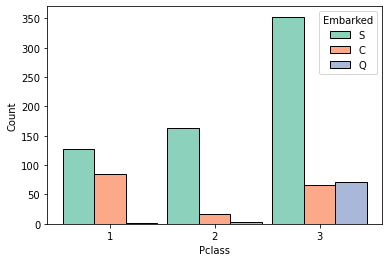

In [12]:
sns.histplot(data=reduced, x='Pclass', hue='Embarked', multiple='dodge', palette='Set2', discrete=True, shrink=0.9)
plt.xticks([1,2,3])
plt.show()

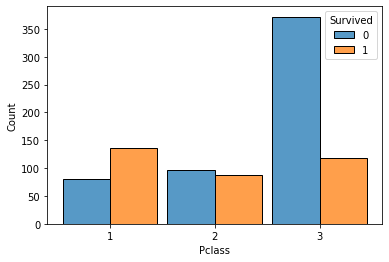

In [11]:
sns.histplot(data=reduced, x='Pclass', hue='Survived', multiple='dodge', discrete=True, shrink=0.9)
plt.xticks([1,2,3])
plt.show()

Looking at the age survivorship distribution, we see that most children under the age of 10 survived with almost every other age group having a less than 50% rate of survival. Curiously there is a very small survivor population very near the 80 age range.

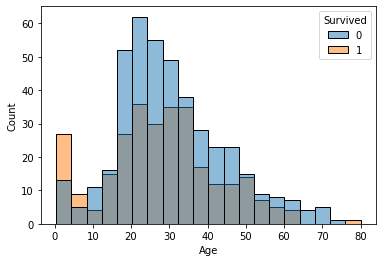

In [13]:
sns.histplot(data=reduced, x='Age', hue='Survived')
plt.show()

Looking at the three wealth columns, "PClass", "Fare", and "Cabin", we see heavy correlations amongst these variables. The vast majority passengers with cabins came from first class, and fairly obviously, first class passengers tended to spend the most money. Second and third class passengers had surprisingly similar fare and cabin distributions.

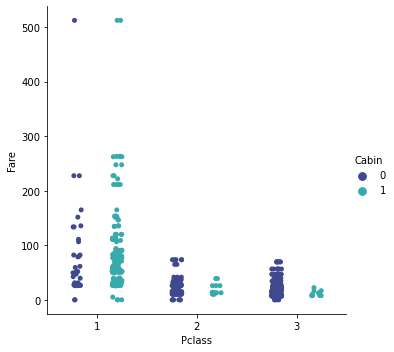

In [14]:
sns.catplot(data=reduced, x='Pclass', y='Fare', hue='Cabin', dodge=True, palette='mako')
plt.show()

Finally, is we check cabin ownership as an indicator for survival, we see that the majority of cabin owners survived, while the majority of those without a cabin died, and that over 75 percent of passengers did not have a cabin.

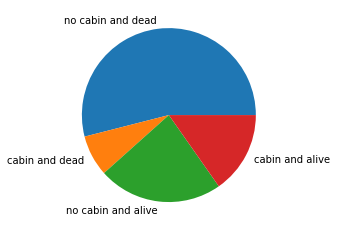

In [15]:
cabin_groups = [len(reduced[(reduced['Cabin']==0) & (reduced['Survived']==0)]),
                len(reduced[(reduced['Cabin']==1) & (reduced['Survived']==0)]),
                len(reduced[(reduced['Cabin']==0) & (reduced['Survived']==1)]),
                len(reduced[(reduced['Cabin']==1) & (reduced['Survived']==1)])]
plt.pie(cabin_groups, labels = ['no cabin and dead', 'cabin and dead', 'no cabin and alive', 'cabin and alive'])
plt.show()

On to the machine learning section. The "age" and "embarked" columns contained a few missing values, and we therefore imputed those missing values using mean for age and mode for embarked. Extra columns indicating missing age/embarked values were appended to the dataframe.

In [10]:
mean_age = float(round(reduced.Age.mean()))
mean_age_test = float(round(reduced_test.Age.mean()))
mode_emb = reduced.Embarked.mode()
mode_emb_test = reduced_test.Embarked.mode()
age_missing = reduced.Age.isna()
emb_missing = reduced.Embarked.isna()
age_missing_test = reduced_test.Age.isna()
emb_missing_test = reduced_test.Embarked.isna()


def impute(row):
    
    if not row['Age'] > 0:
        row['Age'] = mean_age
    
    if type(row['Embarked']) == float:
        row['Embarked'] = 'S'
    return row


imputed_reduced = reduced.apply(impute, axis=1)
imputed_reduced_test = reduced_test.apply(impute, axis=1)
imputed_reduced['age_missing'] = age_missing
imputed_reduced['emb_missing'] = emb_missing
imputed_reduced_test['age_missing'] = age_missing_test
imputed_reduced_test['emb_missing'] = emb_missing_test

The "embarked" column was encoded using one hot encoding, which is fairly standard for this type of column.

In [24]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder_test = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded=pd.DataFrame(encoder.fit_transform(imputed_reduced.loc[:,['Embarked']]))
oh_imputed_reduced = pd.concat([imputed_reduced.drop(['Embarked'], axis=1), encoded], axis=1)
encoded_test=pd.DataFrame(encoder_test.fit_transform(imputed_reduced_test.loc[:,['Embarked']]))
oh_imputed_reduced_test = pd.concat([imputed_reduced_test.drop(['Embarked'], axis=1), encoded_test], axis=1)

Using an XGBClassifier, and splitting the training data into train/validation sets, we typically got a validation accuracy of ~80% or higher using a random 80/20 train/validation split.

In [32]:
params={'objective': 'binary:logistic', 'max_depth':6, 'eval_metric':'logloss'}
model = XGBClassifier(**params, use_label_encoder=False, n_estimators=100, learning_rate=0.2)
X = oh_imputed_reduced.iloc[:,1:]
y = oh_imputed_reduced['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)
prediction = model.predict(X_test)
print(accuracy_score(prediction, y_test))

0.8156424581005587


As a baseline benchmark, I made a simple survival_score function to roughly estimate survival for each passenger. The scoring is described by the function below, giving points for indicators such as being female, having a cabin, being of a wealthier passenger class, under the age of 10, and spending over 100 for the fee. Passengers with a score of 2 or higher are marked as survivors.  Through this rough scoring system, I achieved an accuracy of 76 percent, which is certainly better than flipping a coin, but not quite as good as the model produced using XGBoost. Incorporating the validation data into the training data would likely make the accuracy of the model even better.

In [13]:
def survival_score(row):
    score = 0
    score += row['Sex']
    score += row['Cabin']
    score += 3 - row['Pclass']
    if row['Age'] <= 10:
        score += 1
    if row['Fare'] >= 100:
        score += 1
    return score

I finally plotted my naive survivor score survivorship distribution, and found that while the scoring metric was somewhat accurate, the distribution had some weird outliers. Those with a score of 3 had a lower survival rate than those with a score of 2, and no one with a score of 6 survived.

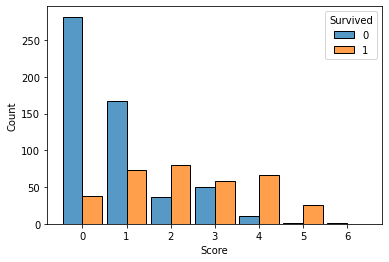

In [16]:
survival_scores = [survival_score(oh_imputed_reduced.iloc[i, :]) for i in range(len(oh_imputed_reduced))]
survival_df = oh_imputed_reduced.loc[:, ['Survived']]
survival_df['Score'] = survival_scores
sns.histplot(data=survival_df, x='Score', hue='Survived', discrete=True, multiple='dodge', shrink=0.9)
plt.show()

In [17]:
guess = len(survival_df[(survival_df['Score'] >= 2) & (survival_df['Survived'] == 1)]) + len(survival_df[(survival_df['Score'] < 2) & (survival_df['Survived'] == 0)])
print(guess/len(survival_df))

0.7631874298540965


Finally for fun, I ran a new model trained on the full train set to predict the survivors in the test dataset and submit the results to Kaggle. I got an accuracy of 0.75598. Pretty mediocre!

In [38]:
params={'objective': 'binary:logistic', 'max_depth':6, 'eval_metric':'logloss'}
model = XGBClassifier(**params, use_label_encoder=False, n_estimators=14, learning_rate=0.2)
X = oh_imputed_reduced.iloc[:,1:]
y = oh_imputed_reduced['Survived']
model.fit(X, y, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=14, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [56]:
final_survival = model.predict(oh_imputed_reduced_test)
final = test.loc[:,['PassengerId']]
final['Survived'] = final_survival

In [59]:
#final.to_csv('survivors.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
